In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Install the Prophet package
!pip install prophet

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [46]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
file_path = '/content/drive/My Drive/PJME_hourly.csv'
pjme = pd.read_csv(file_path, index_col=[0], parse_dates=[0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


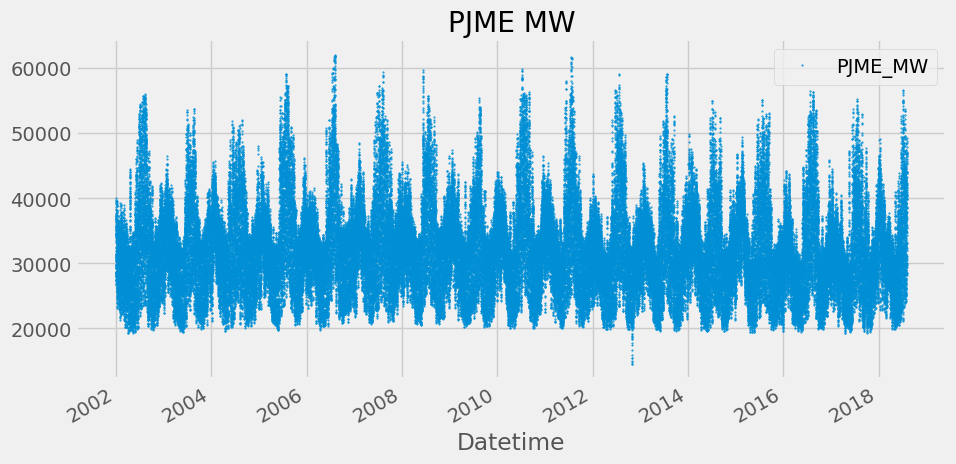

In [48]:
color_pal = sns.color_palette()
pjme.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='PJME MW')
plt.show()

**Time Series Features**

In [49]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month * 100 + df.date.dt.day - 320) % 1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter'])
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'weekday', 'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)


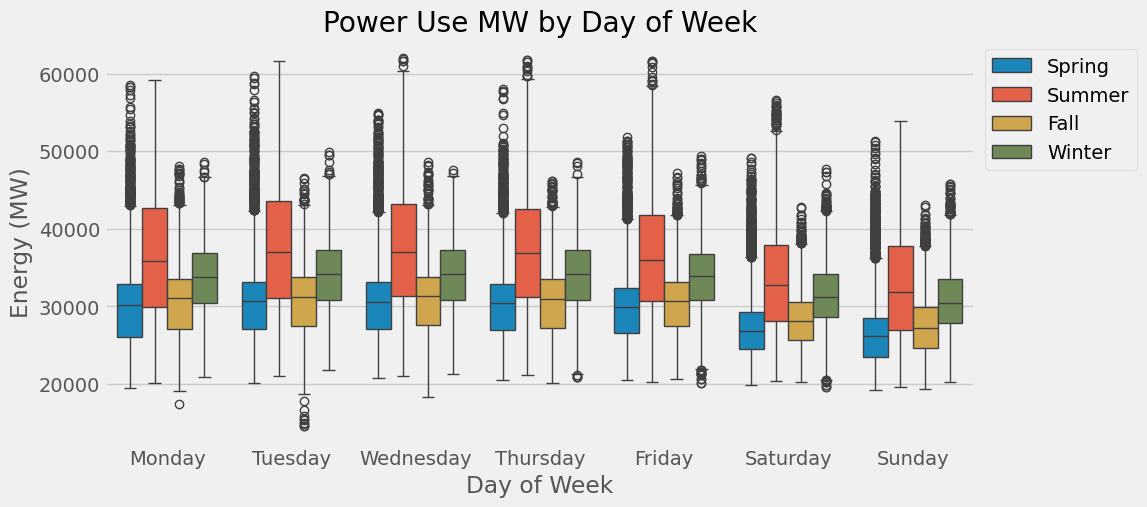

In [50]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

**Train / Test Split**

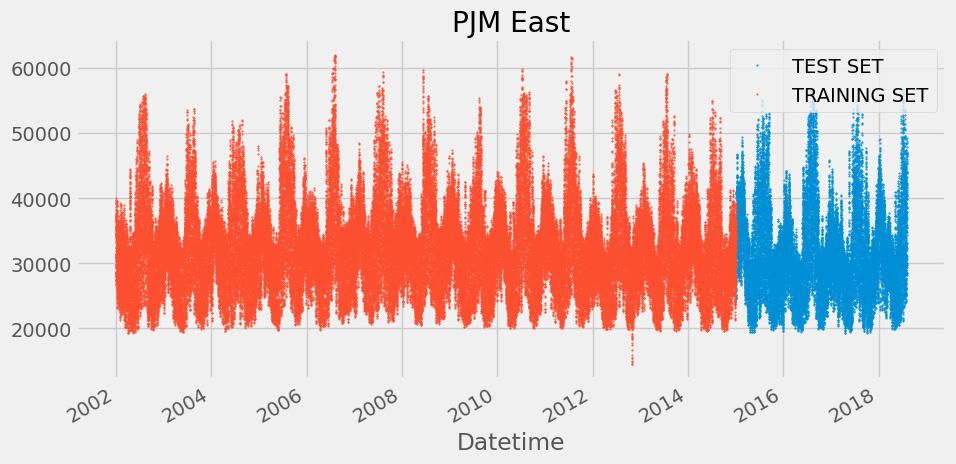

In [51]:
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
plt.show()


**Simple Prophet Model**


Prophet model expects the dataset to be named a specific way. Renaming the dataframe columns before feeding it into the model.

*   Datetime column named: ds
*   target : y




In [52]:
# Format data for prophet model using ds and y
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

In [53]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzdi2qu7/wnma_keq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzdi2qu7/srp11uz5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90898', 'data', 'file=/tmp/tmpxzdi2qu7/wnma_keq.json', 'init=/tmp/tmpxzdi2qu7/srp11uz5.json', 'output', 'file=/tmp/tmpxzdi2qu7/prophet_modelw2qfjogr/prophet_model-20240708161024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:10:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:12:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 15.6 s, sys: 522 ms, total: 16.1 s
Wall time: 1min 57s


In [54]:
# Predict on test set with model
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)

In [55]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31210.530967,23972.621749,32534.703058,31210.530967,31210.530967,-2893.742472,-2893.742472,-2893.742472,-4430.272423,...,1281.328732,1281.328732,1281.328732,255.201219,255.201219,255.201219,0.0,0.0,0.0,28316.788495
1,2015-01-01 02:00:00,31210.494154,22112.774330,31022.059331,31210.494154,31210.494154,-4398.239425,-4398.239425,-4398.239425,-5927.272577,...,1272.574102,1272.574102,1272.574102,256.459050,256.459050,256.459050,0.0,0.0,0.0,26812.254729
2,2015-01-01 03:00:00,31210.457342,21610.603857,30621.998870,31210.457342,31210.457342,-5269.974485,-5269.974485,-5269.974485,-6790.346308,...,1262.613389,1262.613389,1262.613389,257.758434,257.758434,257.758434,0.0,0.0,0.0,25940.482857
3,2015-01-01 04:00:00,31210.420529,21252.167901,30215.044400,31210.420529,31210.420529,-5411.456410,-5411.456410,-5411.456410,-6922.126021,...,1251.570211,1251.570211,1251.570211,259.099400,259.099400,259.099400,0.0,0.0,0.0,25798.964119
4,2015-01-01 05:00:00,31210.383716,21996.682851,30903.873892,31210.383716,31210.383716,-4737.018106,-4737.018106,-4737.018106,-6237.080479,...,1239.580401,1239.580401,1239.580401,260.481971,260.481971,260.481971,0.0,0.0,0.0,26473.365610


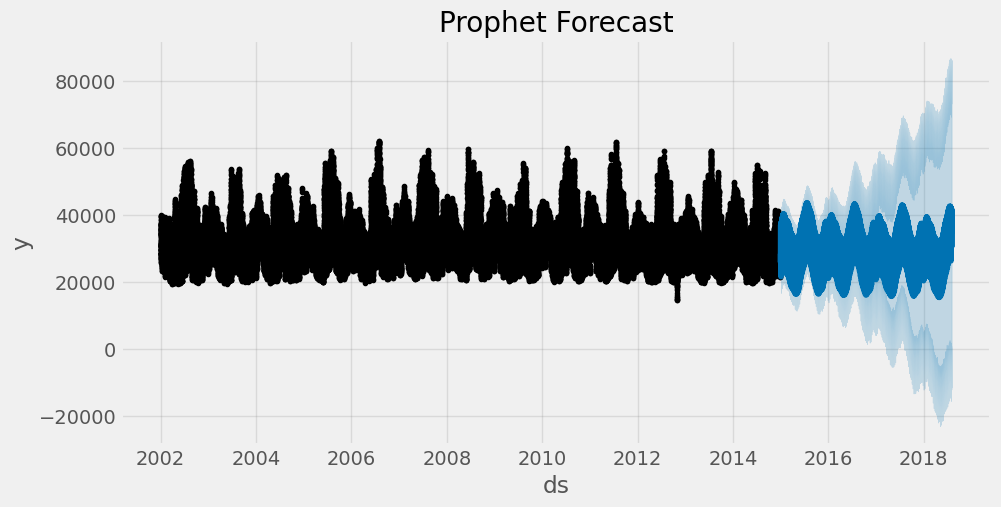

In [56]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

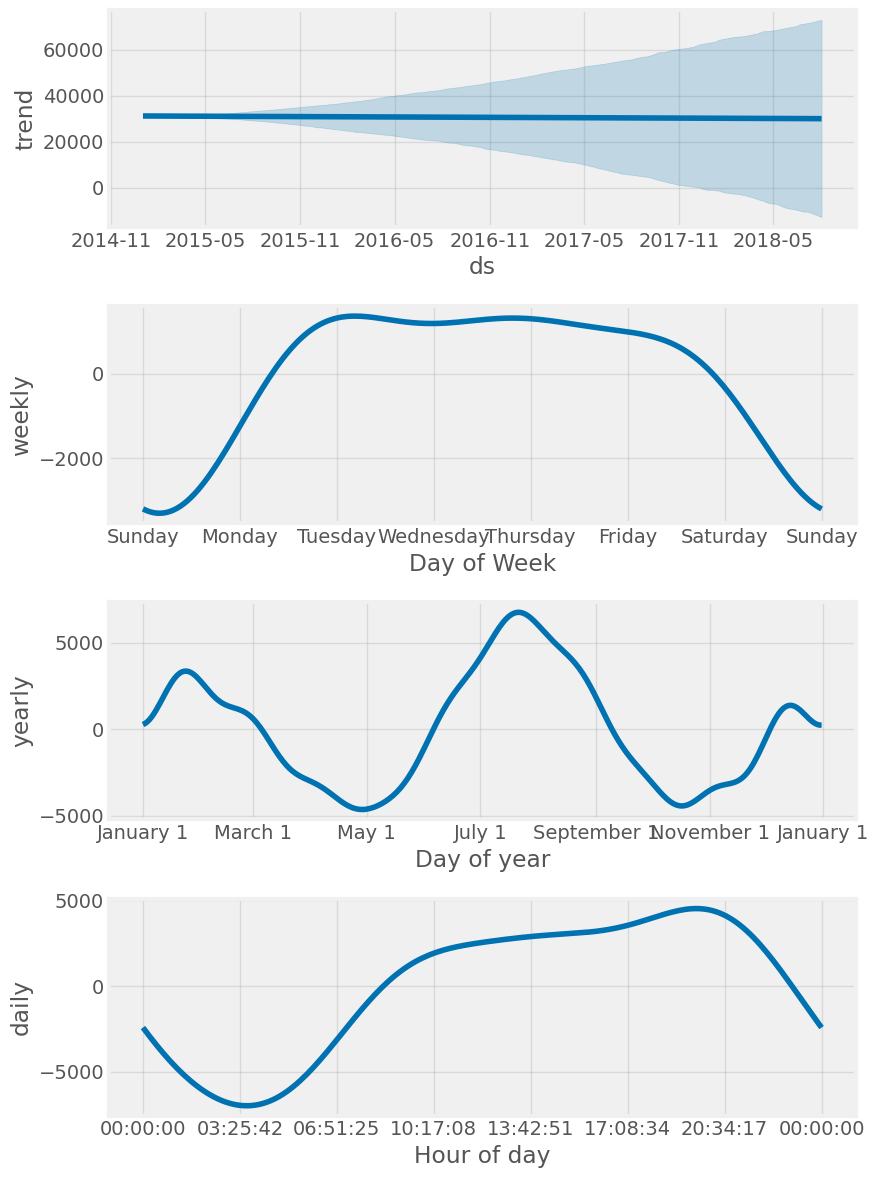

In [57]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

**Compare Forecast to Actual Data**

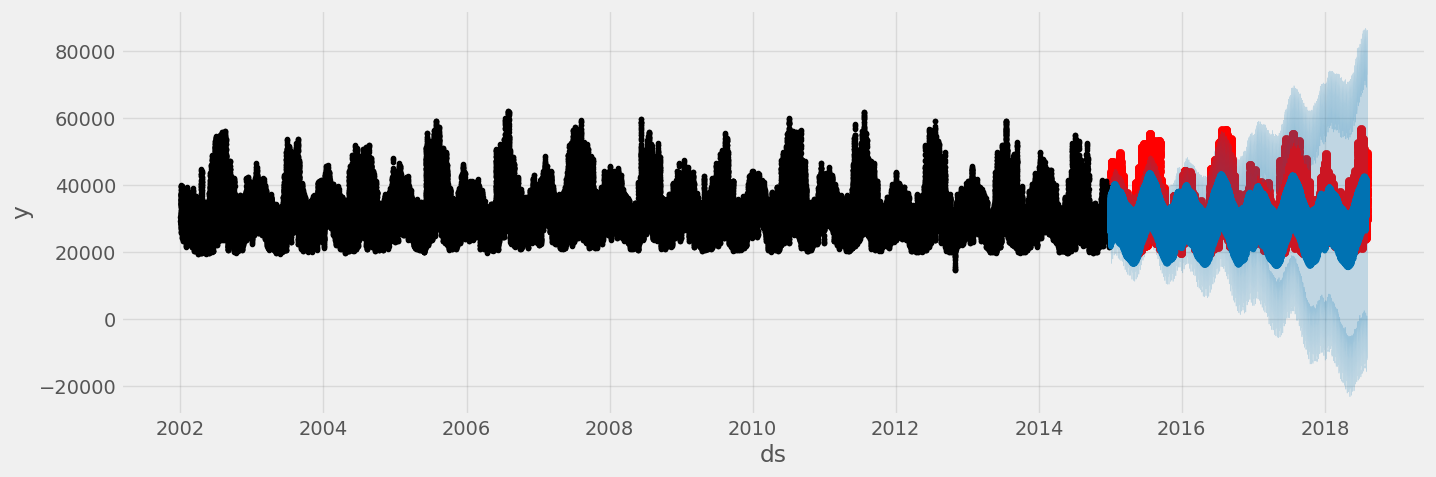

In [58]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

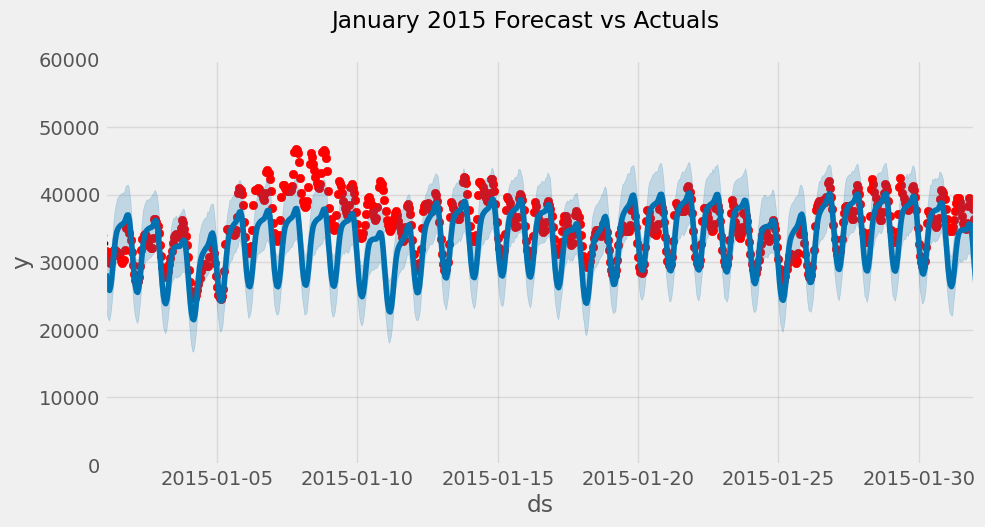

In [59]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

# Convert string dates to datetime objects
start_date = pd.to_datetime('2015-01-01')
end_date = pd.to_datetime('2015-02-01')

ax.set_xbound(lower=start_date, upper=end_date)
ax.set_ylim(0, 60000)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5)) # Adjust the interval as needed

plot = plt.suptitle('January 2015 Forecast vs Actuals')
plt.show()


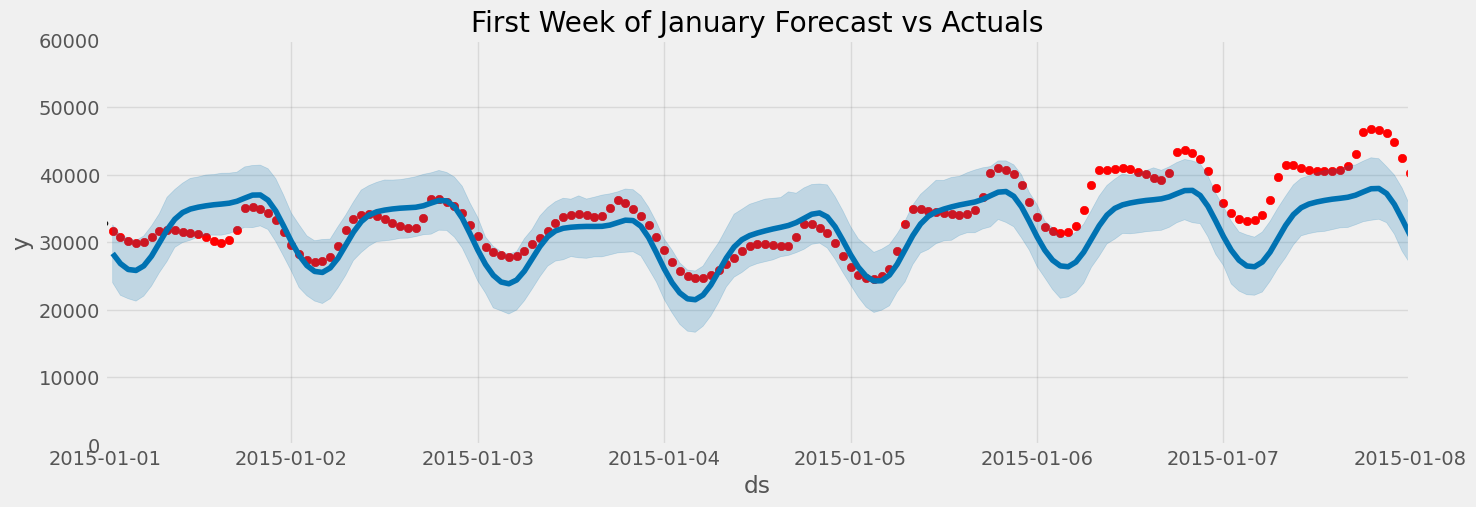

In [60]:
# Plot the forecast with the actuals
import matplotlib.dates as mdates

# Convert string dates to datetime objects
start_date = pd.to_datetime('2015-01-01')
end_date = pd.to_datetime('2015-01-08')

# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=start_date, upper=end_date)
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')

# Format the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Adjust the interval as needed

plt.show()


**Evaluate the model with error metrics**

In [61]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat']))

6616.966074225221

In [62]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

5181.911537928106

In [63]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

16.512003880182647

**Predict into the Future**

We can use the built in make_future_dataframe method to build our future dataframe and make predictions.

In [66]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model.predict(future)

In [67]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2015-01-01 01:00:00,28316.788495
1,2015-01-01 02:00:00,26812.254729
2,2015-01-01 03:00:00,25940.482857
3,2015-01-01 04:00:00,25798.964119
4,2015-01-01 05:00:00,26473.365610
